Everything in this notebook is my work for the sixth exercise of the AML course.

# Data loading and preprocessing

(1) Initialize matrix $\textbf{X} \in \mathbb{R}^{100 \times 1} $ is initialized using normal distribution with mean  $\mu$ = 1  and standard deviation  $\sigma = 0.05 $. 

(2) Generate target $ y \in \mathbb{R}^{100 \times 1} $
The target $ y $ is generated using the formula:

$$
y = 1.3x^2 + 4.8x + 8 + \psi
$$

where $ \psi \in \mathbb{R}^{100 \times 1} $ is randomly initialized noise.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error


X = np.random.normal(1, 0.05, 100)
y = 1.3 * X**2 + 4.8 * X + 8 + np.random.normal(0, 0.1, 100)

D1 = pd.DataFrame({
    "X": X,
    "y": y,
})

D1.head()

,X,y
0,0.963196,13.819166
1,1.044838,14.590204
2,1.031753,14.374465
3,1.036333,14.395690
4,1.019346,14.309952


In [2]:
X = D1["X"].values.reshape(-1, 1)
y = D1["y"].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

Wine Quality Dataset

In [3]:
red_wine_data = pd.read_csv("wine_quality_data/winequality-red.csv", sep=';')
red_wine_data.head()            

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


(1) Convert the non-numeric values to numeric

In [4]:
red_wine_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

After checking if there are any non-numeric values, we can conclude that we don't have and we don't have anything to transform.

(2) Handle sparse data / missing values

In [5]:
red_wine_data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

The red wine dataset has no missing data. We don't have to handle anything.

(3) Split the data, normalize and add bias

In [6]:
red_wine_Xdata = red_wine_data.drop(columns=['quality'])
red_wine_Ydata = red_wine_data['quality']

red_wine_Xtrain, red_wine_Xtest, red_wine_Ytrain, red_wine_Ytest = train_test_split(
    red_wine_Xdata, red_wine_Ydata, test_size=0.2
)

scaler = StandardScaler()
red_wine_Xtrain = scaler.fit_transform(red_wine_Xtrain)
red_wine_Xtest = scaler.transform(red_wine_Xtest)

red_wine_Xtrain = np.c_[np.ones(red_wine_Xtrain.shape[0]), red_wine_Xtrain]
red_wine_Xtest = np.c_[np.ones(red_wine_Xtest.shape[0]), red_wine_Xtest]

red_wine_Ytrain = red_wine_Ytrain.values
red_wine_Ytest = red_wine_Ytest.values

# Generalized Linear Models with Scikit-Learn

In this task, I use *scikit-learn* implementations of linear regression:

* OLS (Ordinary Least Squares)
* Ridge Regression 
* LASSO
* OLS using SGD (Stochastic Gradient Descent)
* Ridge Regression using SGD
* LASSO using SGD

I choose different regularizations strength for each model, apply Grid Search and evaluate the models using Cross Validation.

OLS Train RMSE: 0.6406
OLS Test RMSE: 0.6705


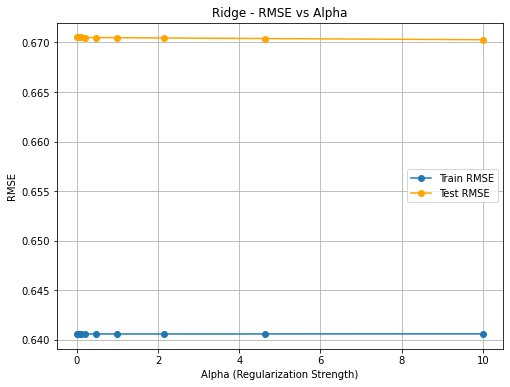

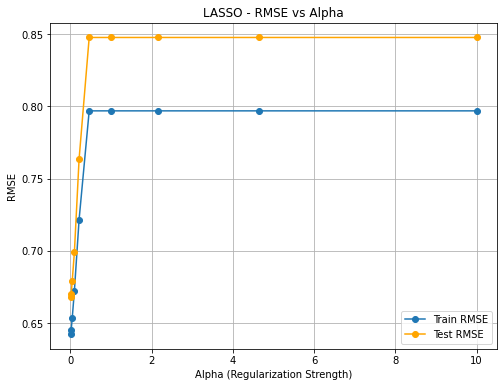

SGD_OLS Train RMSE: 0.6413
SGD_OLS Test RMSE: 0.6733


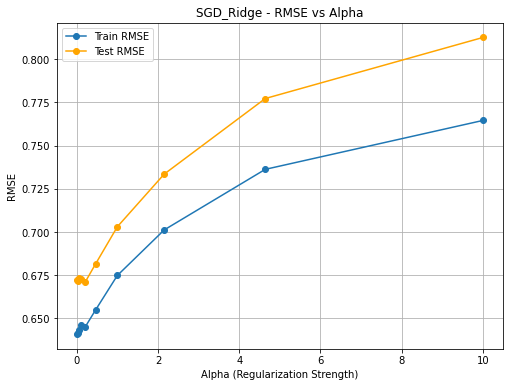

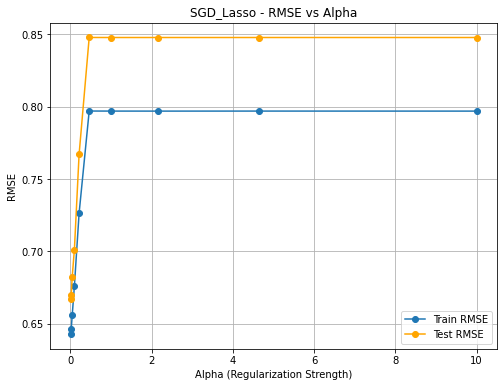

In [7]:
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(),
    "LASSO": Lasso(),
    "SGD_OLS": SGDRegressor(),
    "SGD_Ridge": SGDRegressor(penalty='l2'),
    "SGD_Lasso": SGDRegressor(penalty='l1')
}

# I choose 10 values for alpha, instead of 3,
# because it gives us more information about how the model behaves
alpha = np.logspace(-2, 1, num=10)

hyperparams = {
    "Ridge": {"alpha": alpha},
    "LASSO": {"alpha": alpha},
    "SGD_Ridge": {"alpha" : alpha},
    "SGD_Lasso": {"alpha" : alpha}
}

results = {}

for name, model in models.items():
    if name == "OLS" or name == "SGD_OLS":
        model.fit(red_wine_Xtrain, red_wine_Ytrain)
        y_pred_train = model.predict(red_wine_Xtrain)
        y_pred_test = model.predict(red_wine_Xtest)
        print(f"{name} Train RMSE: {np.sqrt(mean_squared_error(red_wine_Ytrain, y_pred_train)):.4f}")
        print(f"{name} Test RMSE: {np.sqrt(mean_squared_error(red_wine_Ytest, y_pred_test)):.4f}")
    else:
        alphas = hyperparams[name]["alpha"]
        train_rmse = []
        test_rmse = []
        
        for alpha in alphas:
            model.set_params(alpha=alpha)
            model.fit(red_wine_Xtrain, red_wine_Ytrain)
            y_pred_train = model.predict(red_wine_Xtrain)
            y_pred_test = model.predict(red_wine_Xtest)
            train_rmse.append(np.sqrt(mean_squared_error(red_wine_Ytrain, y_pred_train)))
            test_rmse.append(np.sqrt(mean_squared_error(red_wine_Ytest, y_pred_test)))
        
        results[name] = {"alphas": alphas, "train_rmse": train_rmse, "test_rmse": test_rmse}
        plt.figure(figsize=(8, 6))
        plt.plot(alphas, train_rmse, marker='o', label="Train RMSE")
        plt.plot(alphas, test_rmse, marker='o', label="Test RMSE", color="orange")
        plt.xlabel("Alpha (Regularization Strength)")
        plt.ylabel("RMSE")
        plt.title(f"{name} - RMSE vs Alpha")
        plt.legend()
        plt.grid()
        plt.show()
    

# Analysis of the results

Most of the models show similar results. When we increase the regularization strength, the RMSE for both training and testing data increases. This is because the model underfits and can't generalize well. We see that closed-form Ridge Regression keeps the same value for RMSE across all value for regularization strength, while the closed-form Lasso Regression doesn't behave like this. This is because of the characteristics of both regularization types. L1-regularization encourages sparsity by forcing some coefficients to become zero, making only part of the features matter for the predictions. This effects models complexity and it makes it more prone to underfitting. L2-regularization doesn't behave like this. Coefficients can become very small, but not zero. This means L2-regularization doesn't lead to as extreme reductions in model complexity as Lasso. This can be also seen on the two graphs using SGD. Values of Ridge Regression's RMSE with SGD is smoother than these of Lasso Regression with SGD. Simple Linear Regression doesn't have regularization, which, depending on the case, can be plus and minus. If Simple Linear Regression overfits the data, it's a minus, because we don't have regularization to control the values of the coefficient. It's plus, because the model is simple and we don't have to think about the value of the regularization. 

Ridge Best Parameters: alpha = 10.0


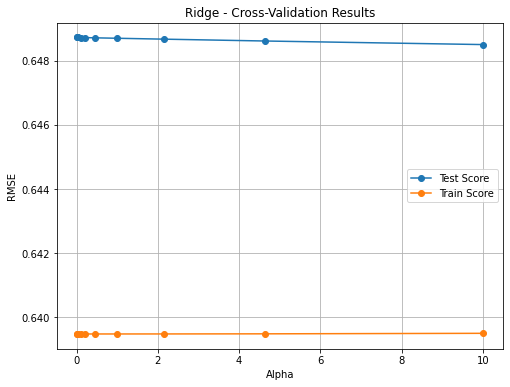

LASSO Best Parameters: alpha = 0.01


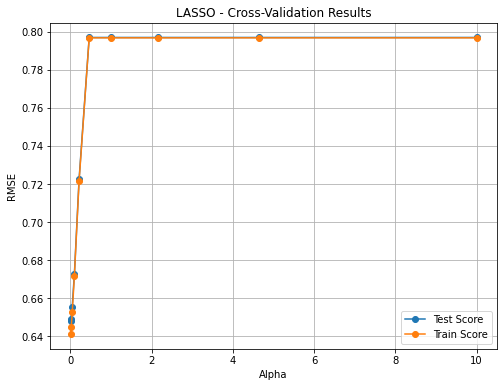

SGD_Ridge Best Parameters: alpha = 0.01


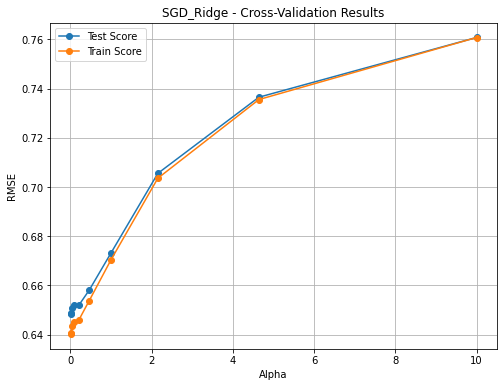

SGD_Lasso Best Parameters: alpha = 0.01


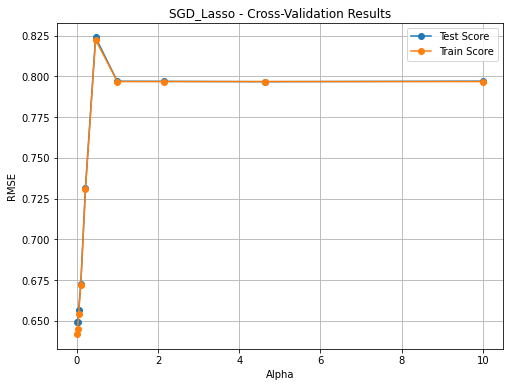

In [8]:
grid_results = {}

for name, model in models.items():
    if name != "OLS" and name != "SGD_OLS":  
        grid = GridSearchCV(
            model,
            param_grid=hyperparams[name],
            scoring='neg_root_mean_squared_error',
            cv=5,
            return_train_score=True
        )
        grid.fit(red_wine_Xtrain, red_wine_Ytrain)
        grid_results[name] = grid
        print(f"{name} Best Parameters: alpha = {grid.best_params_['alpha']}")

        # Plot cross-validation results
        results = pd.DataFrame(grid.cv_results_)
        plt.figure(figsize=(8, 6))
        plt.plot(results["param_alpha"], -results["mean_test_score"], marker='o', label="Test Score")
        plt.plot(results["param_alpha"], -results["mean_train_score"], marker='o', label="Train Score")
        plt.xlabel("Alpha")
        plt.ylabel("RMSE")
        plt.title(f"{name} - Cross-Validation Results")
        plt.legend()
        plt.grid()
        plt.show()

# Analysis of the results

The plots are similar to the previous ones. In almost all cases is choosen the smallest value for the regularization strength. The Ridge Regression favors the simpler models (meaning higher regularization strength), because it generalizes better. Due to the fact that SGD is more unstable in its solutions, SGD Ridge Regression requires higher value for the regularization strength. The trainging and testing RMSE aren't that different in values across all the plots, because Cross-Validation is used, which stabilizes the results.

Using the optimal hyperparameter, I evaluate each model using *cross_val_score*. Then, I plot the results using boxplots.

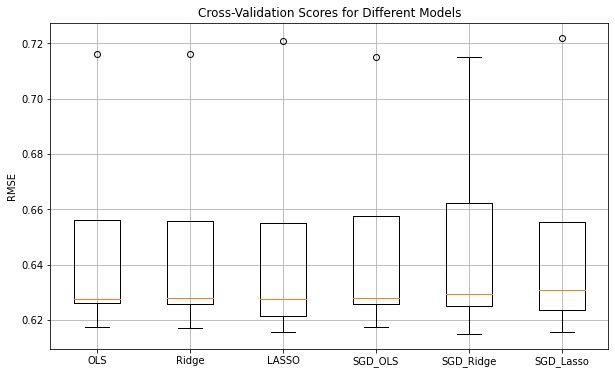

In [9]:
cv_scores = {}
for name, model in models.items():
    if name == "OLS":
        model = LinearRegression()
    elif name == "SGD_OLS":
        model = SGDRegressor()    
    else:
        optimal_alpha = grid_results[name].best_params_["alpha"]
        model.set_params(alpha=optimal_alpha)
    
    scores = cross_val_score(model, red_wine_Xtrain, red_wine_Ytrain, scoring='neg_root_mean_squared_error', cv=5)
    cv_scores[name] = -scores

# Plot cross-validation results using a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores.values(), labels=cv_scores.keys())
plt.ylabel("RMSE")
plt.title("Cross-Validation Scores for Different Models")
plt.grid(True)
plt.show()

The results for all the models are more or less the same. The box plots shows that the RMSE for all the models is around 0.63.

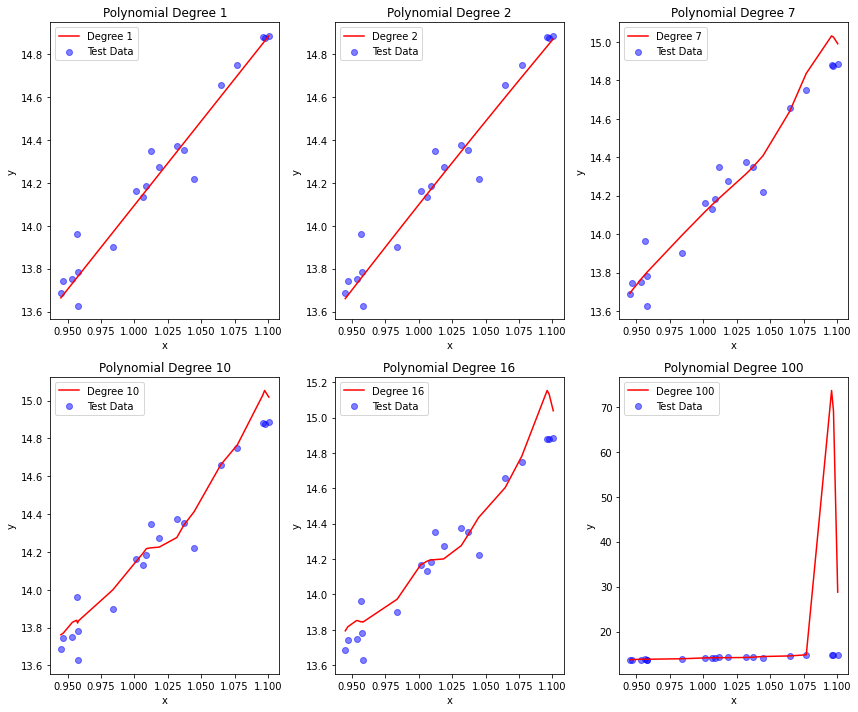

RMSE values for different polynomial degrees:
Degree 1: Train RMSE = 0.093, Test RMSE = 0.090
Degree 2: Train RMSE = 0.093, Test RMSE = 0.091
Degree 7: Train RMSE = 0.085, Test RMSE = 0.101
Degree 10: Train RMSE = 0.080, Test RMSE = 0.106
Degree 16: Train RMSE = 0.076, Test RMSE = 0.133
Degree 100: Train RMSE = 0.074, Test RMSE = 18.139


In [10]:
degrees = [1, 2, 7, 10, 16, 100]

plt.figure(figsize=(12, 10))

train_rmse_values = []
test_rmse_values = []

for i, degree in enumerate(degrees, 1):
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(Xtrain)  
    X_poly_test = poly.transform(Xtest) 

    model = LinearRegression()
    model.fit(X_poly_train, ytrain)

    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    train_rmse = np.sqrt(mean_squared_error(ytrain, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(ytest, y_test_pred))
    
    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)

    plt.subplot(2, 3, i)
    plt.scatter(Xtest, ytest, color='blue', label='Test Data', alpha=0.5)
    plt.plot(np.sort(Xtest.flatten()), y_test_pred[np.argsort(Xtest.flatten())], color='red', label=f'Degree {degree}')
    plt.title(f"Polynomial Degree {degree}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

plt.tight_layout()
plt.show()

# Display RMSE for each degree
print("RMSE values for different polynomial degrees:")
for degree, train_rmse, test_rmse in zip(degrees, train_rmse_values, test_rmse_values):
    print(f"Degree {degree}: Train RMSE = {train_rmse:.3f}, Test RMSE = {test_rmse:.3f}")

# Analysis of the result

The plots and the values of the training and testing RMSE are very descriptive and show that when we increase the degree of the polynomial, the train RMSE decreases and the test RMSE increases. This is due to the overfitting. The model "memorizes" the training data, but doesn't generalize well. A solution to this problem is adding regularization.

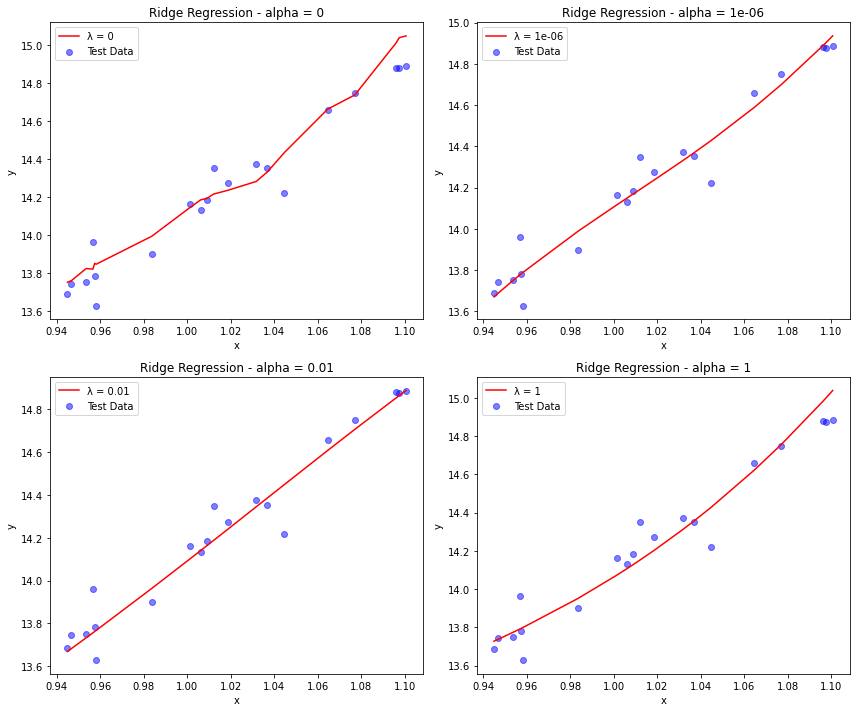

RMSE values for different alpha values in Ridge Regression:
alpha = 0: Train RMSE = 0.080, Test RMSE = 0.109
alpha = 1e-06: Train RMSE = 0.090, Test RMSE = 0.089
alpha = 0.01: Train RMSE = 0.095, Test RMSE = 0.090
alpha = 1: Train RMSE = 0.108, Test RMSE = 0.104


In [11]:
degree = 10
poly = PolynomialFeatures(degree)
X_poly_train = poly.fit_transform(Xtrain)  
X_poly_test = poly.transform(Xtest)  

alpha_values = [0, 1e-6, 1e-2, 1]

plt.figure(figsize=(12, 10))

train_rmse_values_ridge = []
test_rmse_values_ridge = []

for i, alpha in enumerate(alpha_values, 1):
    model = Ridge(alpha=alpha)
    model.fit(X_poly_train, ytrain)
    
    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    train_rmse = np.sqrt(mean_squared_error(ytrain, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(ytest, y_test_pred))
    
    train_rmse_values_ridge.append(train_rmse)
    test_rmse_values_ridge.append(test_rmse)

    plt.subplot(2, 2, i)
    plt.scatter(Xtest, ytest, color='blue', label='Test Data', alpha=0.5)
    plt.plot(np.sort(Xtest.flatten()), y_test_pred[np.argsort(Xtest.flatten())], color='red', label=f'λ = {alpha}')
    plt.title(f"Ridge Regression - alpha = {alpha}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

plt.tight_layout()
plt.show()

print("RMSE values for different alpha values in Ridge Regression:")
for alpha, train_rmse, test_rmse in zip(alpha_values, train_rmse_values_ridge, test_rmse_values_ridge):
    print(f"alpha = {alpha}: Train RMSE = {train_rmse:.3f}, Test RMSE = {test_rmse:.3f}")

# Analysis of the results

We see that the regularization partially fixes the problem here. When we increase the regularization, the train RMSE increases, but the model generalizes better. At some point (here $\alpha$ = 1), the model underfits and stops generalizing well. This is known as bias-variance tradeoff. A popular technique to have low bias and low variance is to select a model with large capacity (e.g. high degree polynomial), and keep the variance in check by choosing appropriate regularization strength.